<ipython-input-13-37fc740cd968>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('none', inplace=True)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


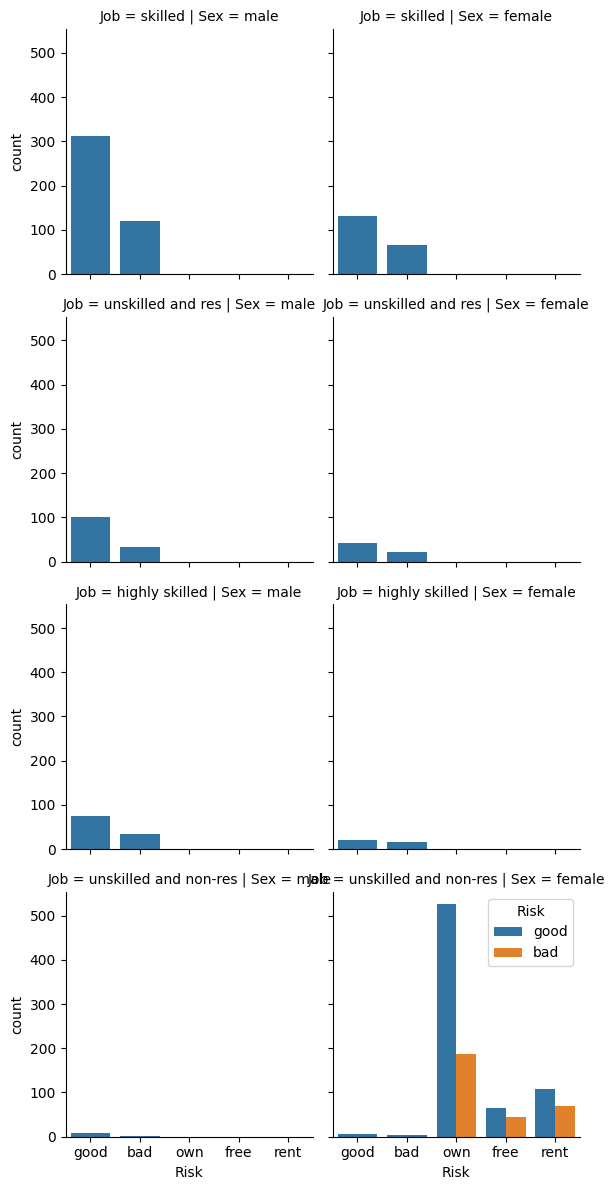

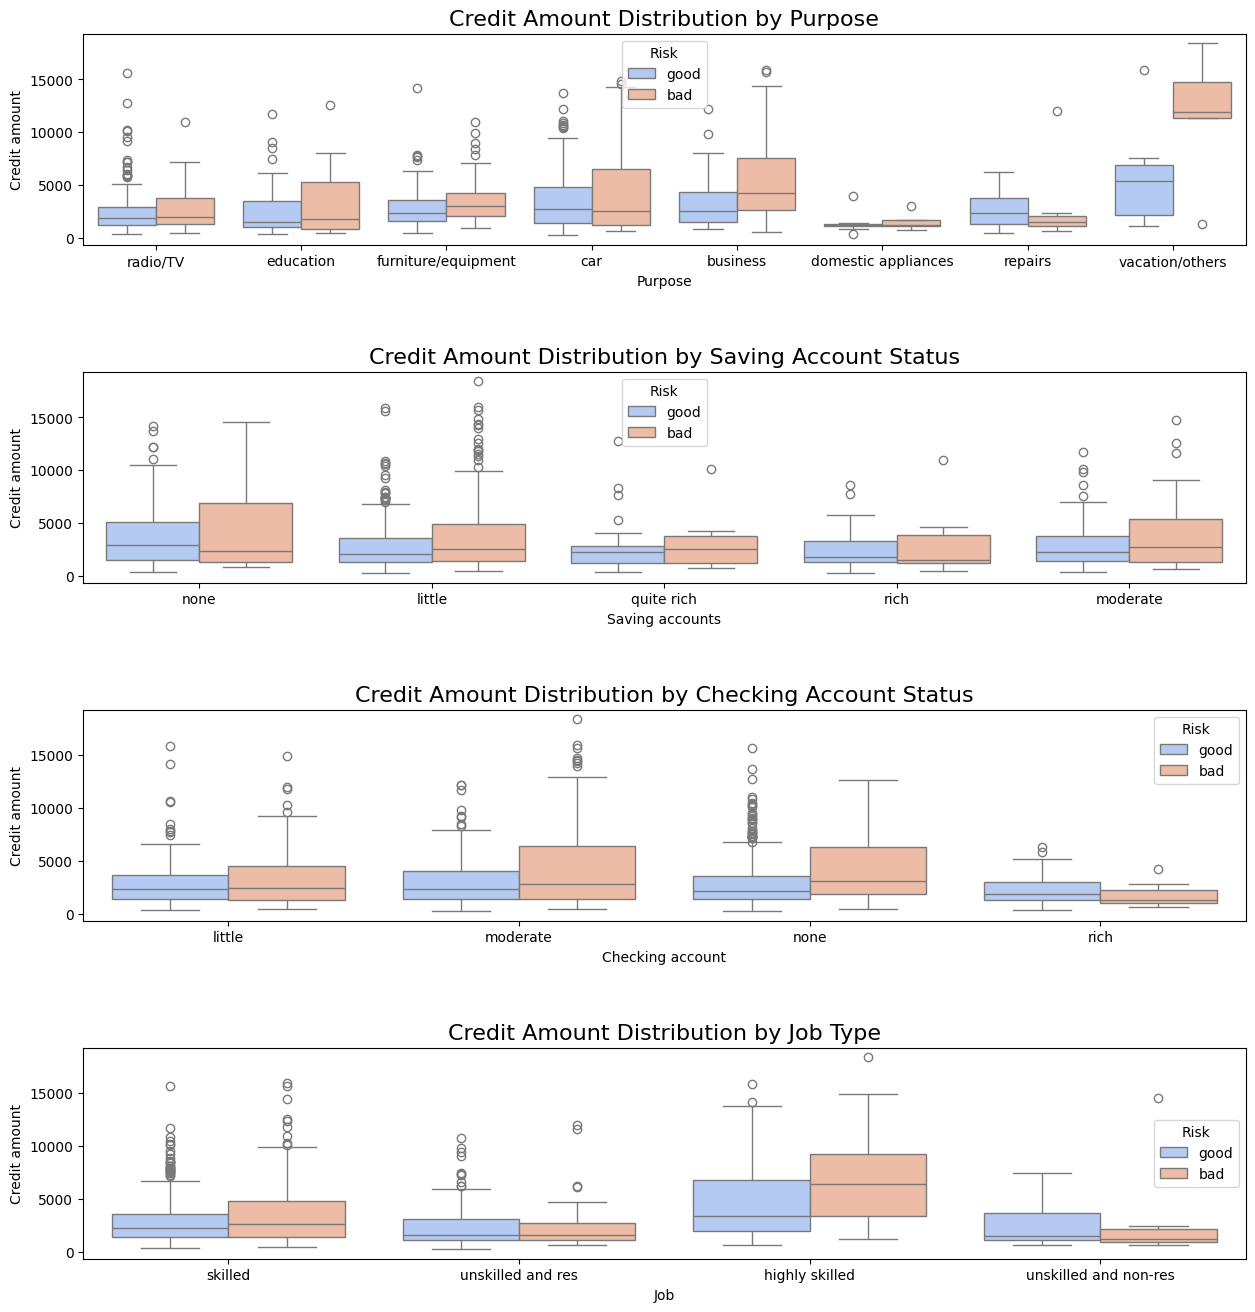

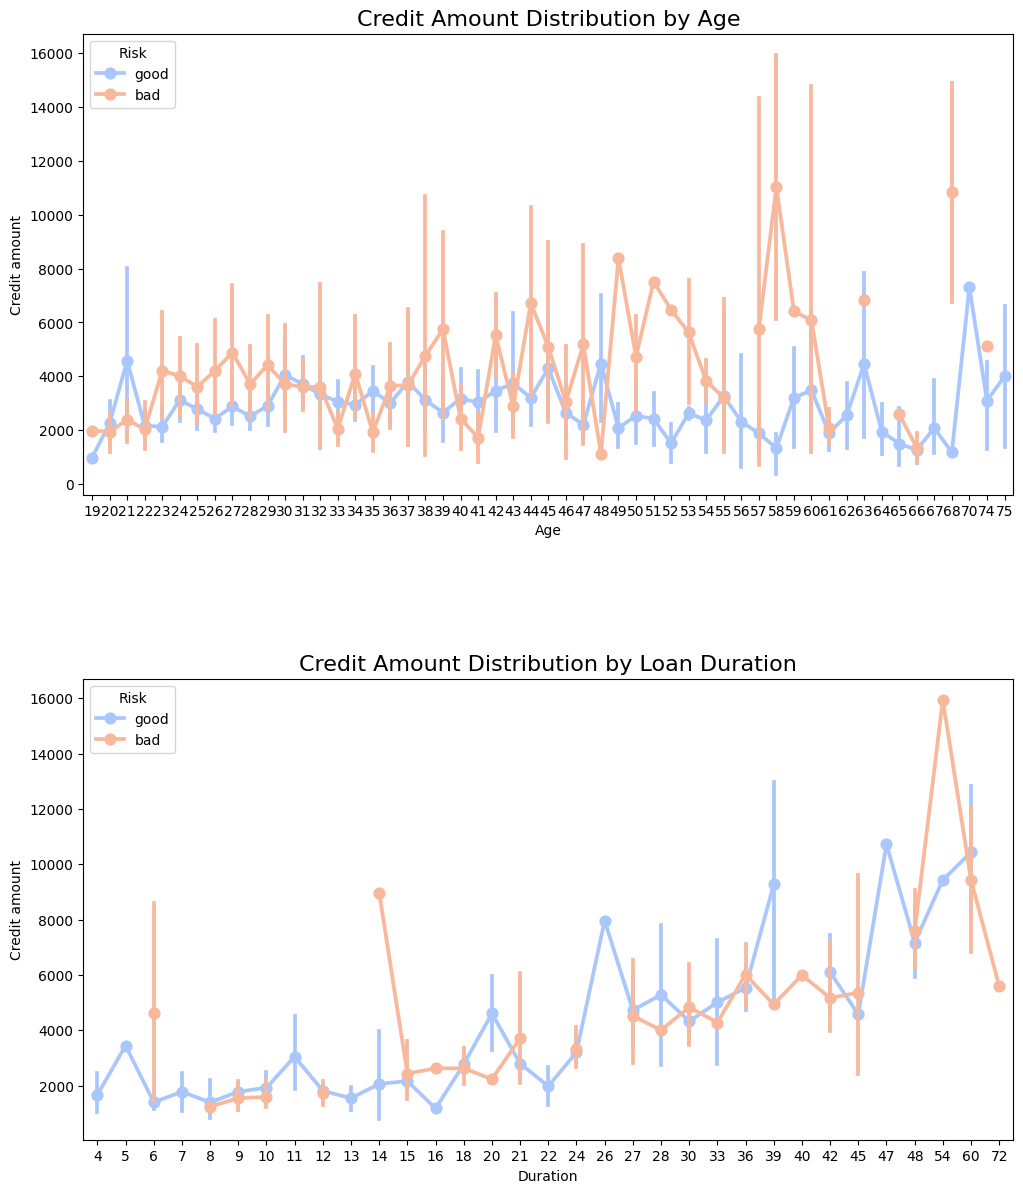

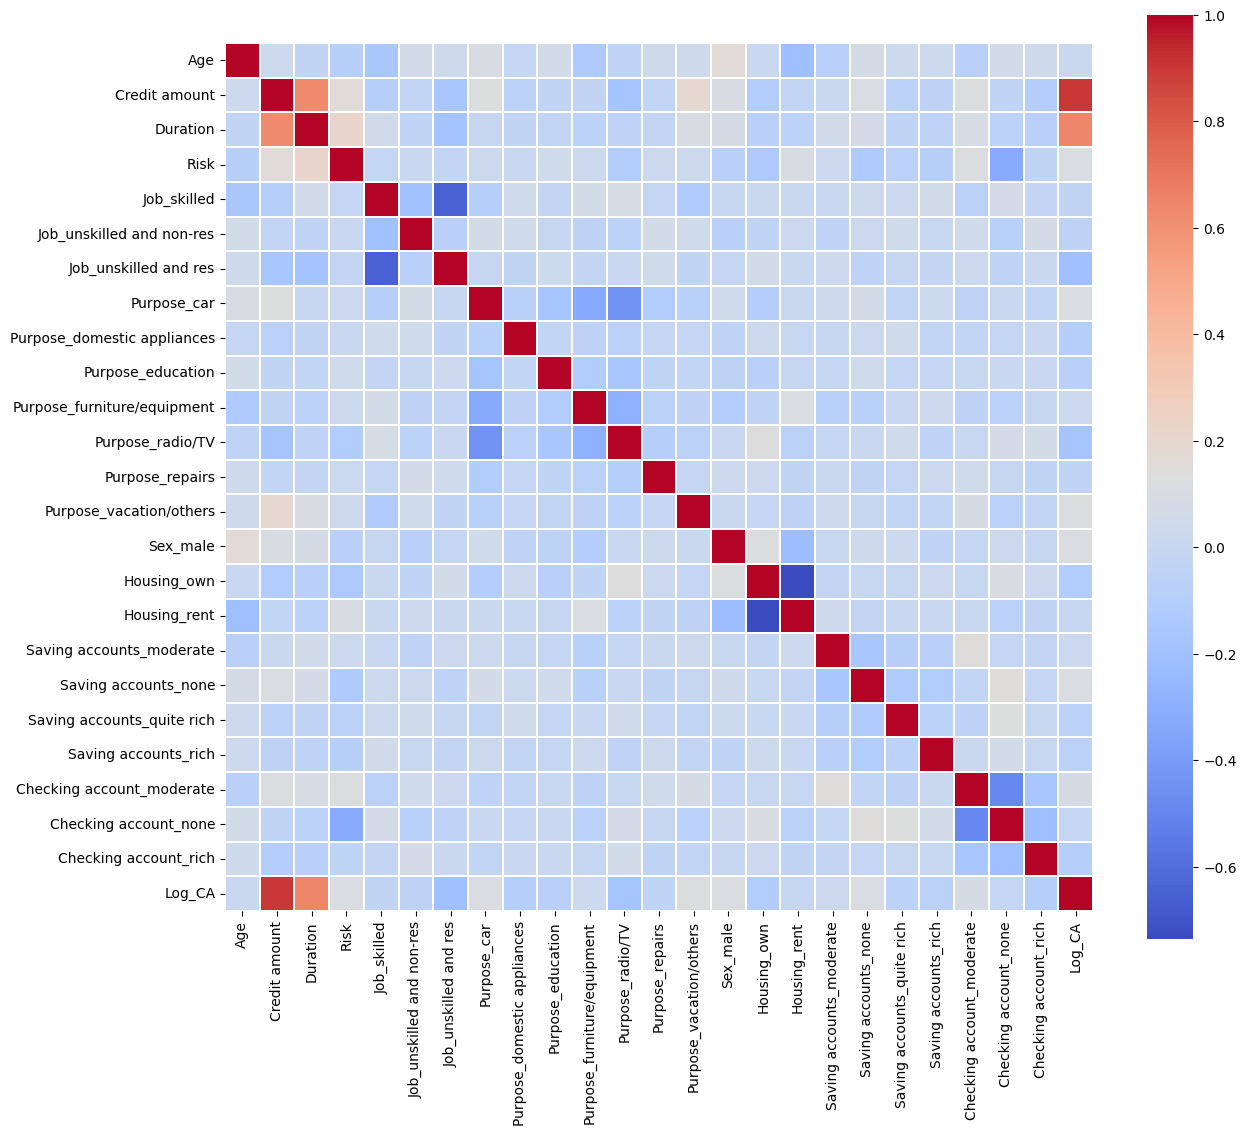

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}
Accuracy: 0.74
Confusion Matrix:
 [[127  14]
 [ 38  21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83       141
           1       0.60      0.36      0.45        59

    accuracy                           0.74       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.72      0.74      0.72       200



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import pickle

# Load the dataset
df = pd.read_csv("german_credit_data.csv", index_col=0)

# Check for missing values
df.isna().sum()

# Fill missing values
for col in ['Saving accounts', 'Checking account']:
    df[col].fillna('none', inplace=True)

# Map 'Job' column to more descriptive labels
job_mapping = {0: 'unskilled and non-res', 1: 'unskilled and res', 2: 'skilled', 3: 'highly skilled'}
df['Job'] = df['Job'].map(job_mapping)

# Exploratory Data Analysis (EDA)
g = sns.FacetGrid(df, col="Sex", row="Job")
g = g.map(sns.countplot, "Risk")

sns.countplot(x="Housing", hue="Risk", data=df)
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,25))

sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.boxplot(x="Saving accounts", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)
sns.boxplot(x="Checking account", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax3)
sns.boxplot(x="Job", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax4)

ax1.set_title("Credit Amount Distribution by Purpose", fontsize=16)
ax2.set_title("Credit Amount Distribution by Saving Account Status", fontsize=16)
ax3.set_title("Credit Amount Distribution by Checking Account Status", fontsize=16)
ax4.set_title("Credit Amount Distribution by Job Type", fontsize=16)

plt.subplots_adjust(hspace=0.6, top=0.6)
plt.show()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,14))

sns.pointplot(x="Age", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.pointplot(x="Duration", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)

ax1.set_title("Credit Amount Distribution by Age", fontsize=16)
ax2.set_title("Credit Amount Distribution by Loan Duration", fontsize=16)

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
plt.show()

# One-Hot Encoding for categorical variables
dummies_columns = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
for col in dummies_columns:
    df = df.merge(pd.get_dummies(df[col], drop_first=True, prefix=str(col)), left_index=True, right_index=True)

# Encoding the target variable (Risk)
risk_mapping = {"good": 0, "bad": 1}
df['Risk'] = df['Risk'].map(risk_mapping)

# Drop redundant columns
columns_to_drop = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
df.drop(columns_to_drop, axis=1, inplace=True)

# Log transformation of Credit amount
df['Log_CA'] = np.log(df['Credit amount'])

# Visualize correlation
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, linecolor='white', cmap='coolwarm')
plt.show()

# Prepare features and target variables
X = df.drop(['Risk', 'Credit amount'], axis=1).values
y = df['Risk'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define the XGBoost model
xgb = XGBClassifier(eta=0.19, max_depth=8, n_estimators=150, subsample=0.8, colsample_bytree=1)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'eta': [0.1, 0.19, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_xgb = best_xgb.predict(X_test)

# Print evaluation metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy_score(y_pred_xgb, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Save the best model using pickle
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

# Save the columns used for prediction
used_columns = df.drop(['Risk', 'Credit amount'], axis=1).columns.tolist()
with open('model_columns.pkl', 'wb') as file:
    pickle.dump(used_columns, file)



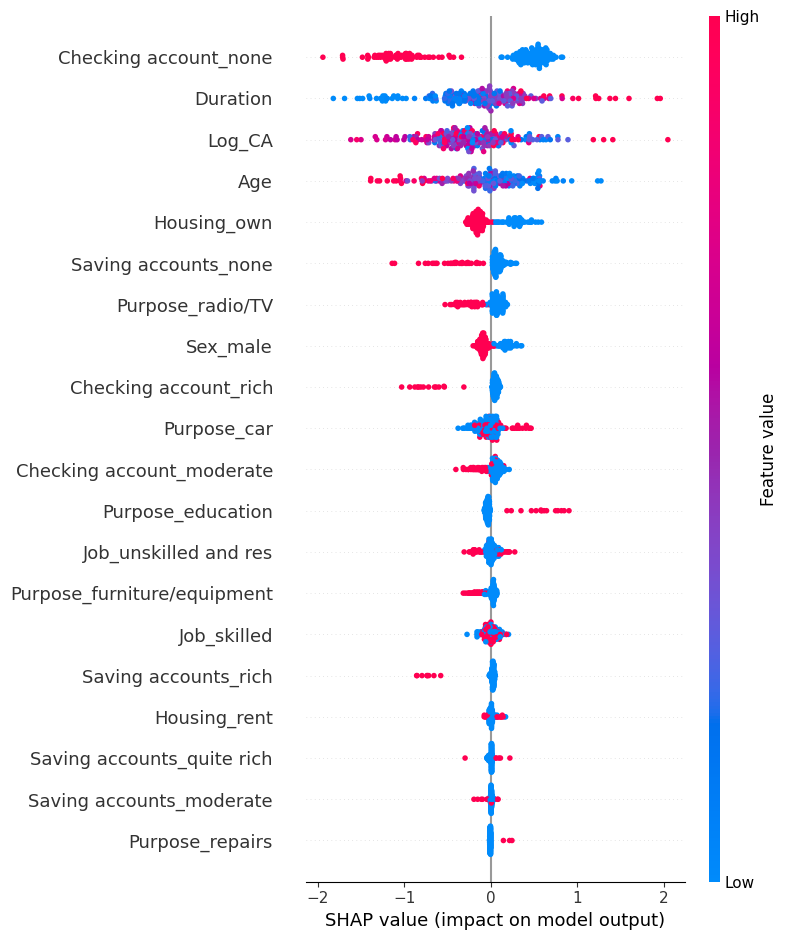

In [ ]:
!pip install shap
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=used_columns)
# SHAP force plot for a single instance


In [ ]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken 2wCgvKv1WNBnOc1NsG6zvRocS4c_3XwykJPWG3zQtyJfNpERs



Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [31]:
%%writefile app.py
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import  numpy as np

# Page Title
st.title("Credit Risk Prediction Using XGBoost")
st.subheader("German Credit Dataset Project")

# Problem Statement and Background
st.header("Problem Statement")
st.markdown("**Predicting Credit Risk for Loan Applicants**")

st.header("Background")
st.write("""
Financial institutions face significant challenges in assessing the creditworthiness of loan applicants.
Accurate credit risk prediction is crucial for minimizing defaults and ensuring the stability of the lending system.
The German Credit dataset provides a comprehensive set of features related to applicants' financial history,
personal information, and loan details, making it an ideal resource for developing predictive models.
""")

# Objective
st.header("Objective")
st.write("""
Develop a machine learning model to predict the credit risk of loan applicants using the German Credit dataset.
The model should classify applicants into two categories: **good credit risk (0)** and **bad credit risk (1)**.
Additionally, it should provide insights into key factors influencing credit risk and suggest strategies for improving the credit evaluation process.
""")

# Methodology
st.header("Methodology")

st.subheader("1. Data Exploration and Preprocessing")

st.markdown("**Dataset Analysis**")
st.write("""
- Target Variable (Risk): 0 for good credit, 1 for bad credit.
- Features: Numerical (Age, Credit amount, Duration), Categorical (Job, Sex, Housing, etc.).
""")
st.code("""# Encoding the target variable (Risk)
risk_mapping = {"good": 0, "bad": 1}
df['Risk'] = df['Risk'].map(risk_mapping)")

""", language="python")

st.markdown("**Data Cleaning**")
st.write("""
- Missing Values: Filled with 'none' for categorical fields like Saving accounts and Checking account.
- Outliers: Applied log transformation to Credit amount to stabilize variance.
""")
st.code("""
        for col in ['Saving accounts', 'Checking account']:
    df[col].fillna('none', inplace=True)

# Map 'Job' column to more descriptive labels
job_mapping = {0: 'unskilled and non-res', 1: 'unskilled and res', 2: 'skilled', 3: 'highly skilled'}
df['Job'] = df['Job'].map(job_mapping)
""", language="python")

st.markdown("**Feature Engineering**")
st.write("""
- Log Transformation: Normalized Credit amount.
- One-Hot Encoding: Converted categorical variables (Job, Sex, Housing, etc.) to numerical format.
""")

st.code("""
# One-Hot Encoding for categorical variables
dummies_columns = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
for col in dummies_columns:
    df = df.merge(pd.get_dummies(df[col], drop_first=True, prefix=str(col)), left_index=True, right_index=True)

# Encoding the target variable (Risk)
risk_mapping = {"good": 0, "bad": 1}
df['Risk'] = df['Risk'].map(risk_mapping)

# Drop redundant columns
columns_to_drop = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
df.drop(columns_to_drop, axis=1, inplace=True)

# Log transformation of Credit amount
df['Log_CA'] = np.log(df['Credit amount'])
""", language="python")



df = pd.read_csv("german_credit_data.csv")

# Assuming your DataFrame is called df
st.subheader("Boxplots: Credit Amount Distribution by Categorical Features")

# Boxplots (4 in one figure)
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 25))

sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.boxplot(x="Saving accounts", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)
sns.boxplot(x="Checking account", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax3)
sns.boxplot(x="Job", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax4)

ax1.set_title("Credit Amount Distribution by Purpose", fontsize=16)
ax2.set_title("Credit Amount Distribution by Saving Account Status", fontsize=16)
ax3.set_title("Credit Amount Distribution by Checking Account Status", fontsize=16)
ax4.set_title("Credit Amount Distribution by Job Type", fontsize=16)

plt.subplots_adjust(hspace=0.6, top=0.95)
st.pyplot(fig1)

# Pointplots (2 in one figure)
st.subheader("Pointplots: Credit Amount vs Age and Duration")

fig2, (ax5, ax6) = plt.subplots(2, 1, figsize=(12, 14))

sns.pointplot(x="Age", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax5)
sns.pointplot(x="Duration", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax6)

ax5.set_title("Credit Amount Distribution by Age", fontsize=16)
ax6.set_title("Credit Amount Distribution by Loan Duration", fontsize=16)

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
st.pyplot(fig2)

st.subheader("2. Model Development")

st.markdown("**Machine Learning Algorithm**")
st.write("""
- Selected XGBoost for its robustness, accuracy, and ability to handle mixed-type data.
""")
st.code("""
# Define the XGBoost model
xgb = XGBClassifier(
    eta=0.19,
    max_depth=8,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=1
)
""", language="python")

st.markdown("**Model Training and Evaluation**")
st.write("""
- Trained on the dataset and evaluated using:
    - Accuracy
    - Precision & Recall
    - F1-Score
""")
st.code("""
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define the XGBoost model
xgb = XGBClassifier(eta=0.19, max_depth=8, n_estimators=150, subsample=0.8, colsample_bytree=1)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'eta': [0.1, 0.19, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_xgb = best_xgb.predict(X_test)

# Print evaluation metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy_score(y_pred_xgb, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

""", language="python")


st.markdown("**Model Optimization**")
st.write("""
- Used GridSearchCV for tuning hyperparameters like `max_depth`, `n_estimators`, `eta`, etc.
- Applied 5-fold Cross-Validation to improve generalization and avoid overfitting.
""")

st.subheader("3. Model Interpretation and Insights")

st.write("""
- Used SHAP (SHapley Additive exPlanations) to interpret model outputs.
- Identified key features like Credit amount, Age, and Duration as major influencers.
""")
st.subheader("SHAP Summary Plot: Feature Importance")
st.image("shap.png", use_column_width=True)


st.markdown("**Actionable Insights**")
st.write("""
- Larger Credit amounts, younger Age, and longer Durations are associated with higher credit risk.
- Recommendation: Prioritize these attributes during evaluation for better decision-making.
""")

# Results
st.header("Results")

st.markdown("**Model Performance Summary**")

st.table({
    "Metric": ["Accuracy", "Precision (0)", "Recall (0)", "F1-score (0)", "Precision (1)", "Recall (1)", "F1-score (1)"],
    "Score": ["0.74", "0.77", "0.90", "0.83", "0.60", "0.36", "0.45"]
})

st.markdown("**Best Hyperparameters (from GridSearchCV)**")
st.code("""
# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')

""", language="python")


# Conclusion
st.header("Conclusion")
st.write("""
- A well-tuned XGBoost model can effectively predict credit risk using customer demographics and financial behavior.
- Insights from SHAP help in understanding the reasoning behind predictions.
- This enhances both prediction accuracy and decision-making transparency for financial institutions.
""")


Overwriting app.py


In [32]:
# Step 4: Launch Streamlit + expose using ngrok
from pyngrok import ngrok
import time

# Kill previous tunnels
ngrok.kill()

# Start Streamlit in the background
!streamlit run app.py &>/content/logs.txt &

# Wait for Streamlit to boot up
time.sleep(5)

# Connect to the default port used by Streamlit
public_url = ngrok.connect("8501", "http")
print(f"App is live at: {public_url}")


App is live at: NgrokTunnel: "https://12f2-34-32-220-205.ngrok-free.app" -> "http://localhost:8501"
